In [1]:
import gym
import os 
import sys
import itertools
import numpy as np
import tensorflow as tf
from collections import defaultdict, namedtuple

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.envs.make('CartPole-v0')
env = env.unwrapped
env.seed(1)

print("env.action_sapce:", env.action_space.n)
print("env.observation_sapce:", env.observation_space.shape[0])
print("env.observation_space.high:", env.observation_space.high)
print("env.observation_space.low:", env.observation_space.low)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
env.action_sapce: 2
env.observation_sapce: 4
env.observation_space.high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
env.observation_space.low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [7]:
class PolicyGradient():
    """
    Policy Gradient REinforcement Learning.
    used a 3 layer neural network as the policy network.
    """
    def __init__(self, n_x, n_y,
                learning_rate=0.01, load_path=None, save_path=None):
        self.n_x = n_x
        self.n_y = n_y
        self.lr = learning_rate
        self.episode_rewards = []
        
        self.__build_network()
        self.sess = tf.Session()
        
        tf.summary.FileWriter("logs_actor/", self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
    def __build_network(self):
        """
        build the natural network
        """
        # Create placeholders
        with tf.name_scope('actor_inputs'):
            self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="state")
            self.Y = tf.placeholder(tf.float32, shape=(self.n_y, None), name="action")
            self.td_error = tf.placeholder(tf.float32, name="td_error")

        layer1_units = 10
        layer2_units = 10
        layer_output_units = self.n_y
        
        with tf.name_scope("actor_parameter"):
            W1 = self.__weigfht_variable([layer1_units, self.n_x], "aW1")
            b1 = self.__bias_bariable([layer1_units, 1], "ab1")
            W2 = self.__weigfht_variable([layer2_units, layer1_units], "aW2")
            b2 = self.__bias_bariable([layer2_units, 1], "ab2")
            W3 = self.__weigfht_variable([layer_output_units, layer2_units], "aW3")
            b3 = self.__bias_bariable([layer_output_units, 1], "ab3")
        
        with tf.name_scope("actor_layer1"):
            z1 = tf.add(tf.matmul(W1, self.X), b1)
            a1 = tf.nn.relu(z1)
        with tf.name_scope("actor_layer2"):
            z2 = tf.add(tf.matmul(W2, a1), b2)
            a2 = tf.nn.relu(z2)
        with tf.name_scope("actor_layer_output"):
            z3 = tf.add(tf.matmul(W3, a2), b3)
            a3 = tf.nn.softmax(z3)

        # Softmax outputs, we need to transpose as tensorflow nn functions expects them in this shape
        logits = tf.transpose(z3)
        labels = tf.transpose(self.Y)
        self.outputs_softmax = tf.nn.softmax(logits, name='A3')

        with tf.name_scope('actor_loss'):
            neg_log_prob = tf.squared_difference(logits, labels)
            loss = tf.reduce_mean(neg_log_prob * self.td_error)

        with tf.name_scope('actor_train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        
    def __weigfht_variable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
    
    def __bias_bariable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
        
    def __disc_and_norm_rewards(self):   
        disc_norm_ep_rewards = np.zeros_like(self.episode_rewards)
        disc_norm_ep_rewards -= np.mean(disc_norm_ep_rewards)
        disc_norm_ep_rewards /= np.std(disc_norm_ep_rewards)
        return disc_norm_ep_rewards
    
    def store_transition(self, error):
        """
        Store memory for network training
        """
        self.episode_rewards.append(error)
    
    def predict(self, state):
        """
        choose action base on given state
        """
        # reshape state to (num_features, 1)
        state = state[:, np.newaxis]
        
        # get softmax probabilities
        prob_weights = self.sess.run(self.outputs_softmax, feed_dict={self.X: state})
        
        # return sampled action
        action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
        return action
        
    def learn(self, state, action, reward):
        """
        Accroding the game memory traing the network
        """
        # discount and normalize episode reward
        disc_norm_ep_reward = self.__disc_and_norm_rewards()
        
        action__ = np.zeros(self.n_y)
        action__[action] = 1
        
        # train on episodes
        self.sess.run(self.train_op, feed_dict={
            self.X: np.vstack(state),
            self.Y: np.vstack(action__),
            self.td_error: disc_norm_ep_reward,  
        })
        
        # Reset the episode data
        self.episode_rewards  = []
        
        return disc_norm_ep_reward

In [4]:
class ValueEstimator():
    """
    Policy Gradient REinforcement Learning.
    used a 3 layer neural network as the policy network.
    """
    def __init__(self, n_x, n_y,
                learning_rate=0.01, load_path=None, save_path=None):
        self.n_x = n_x
        self.n_y = n_y
        self.lr = learning_rate
        self.episode_rewards = []
        
        self.__build_network()
        self.sess = tf.Session()
        
        tf.summary.FileWriter("critic_logs/", self.sess.graph)
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        
    def __build_network(self):
        """
        build the natural network
        """
        # Create placeholders
        with tf.name_scope('critic_inputs'):
            self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="X")
            self.Y = tf.placeholder(tf.float32, name="Y")

        layer1_units = 10
        layer2_units = 10
        layer_output_units = self.n_y
        
        with tf.name_scope("critic_parameter"):
            W1 = self.__weigfht_variable([layer1_units, self.n_x], "cW1")
            b1 = self.__bias_bariable([layer1_units, 1], "cb1")
            W2 = self.__weigfht_variable([layer2_units, layer1_units], "cW2")
            b2 = self.__bias_bariable([layer2_units, 1], "cb2")
            W3 = self.__weigfht_variable([layer_output_units, layer2_units], "cW3")
            b3 = self.__bias_bariable([layer_output_units, 1], "cb3")
        
        with tf.name_scope("critic_layer1"):
            z1 = tf.add(tf.matmul(W1, self.X), b1)
            a1 = tf.nn.relu(z1)
        with tf.name_scope("critic_layer2"):
            z2 = tf.add(tf.matmul(W2, a1), b2)
            a2 = tf.nn.relu(z2)
        with tf.name_scope("critic_layer_output"):
            z3 = tf.add(tf.matmul(W3, a2), b3)
            a3 = tf.nn.relu(z3)

        # transpose as tensorflow nn functions expects them in this shape
        logits = tf.transpose(z3)
        labels = tf.transpose(self.Y)
        self.outputs = tf.nn.relu(logits, name='A3')

        with tf.name_scope('critic_loss'):
            loss = tf.squared_difference(logits, labels)

        with tf.name_scope('critic_train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        
    def __weigfht_variable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
    
    def __bias_bariable(self, shape, name):
        initial = tf.contrib.layers.xavier_initializer(seed=1)
        return tf.get_variable(name, shape, initializer=initial)
        
    def __disc_and_norm_rewards(self):   
        disc_norm_ep_rewards = np.zeros_like(self.episode_rewards)
        disc_norm_ep_rewards -= np.mean(disc_norm_ep_rewards)
        disc_norm_ep_rewards /= np.std(disc_norm_ep_rewards)
        return disc_norm_ep_rewards
    
    def store_transition(self, target):
        """
        Store memory for network training
        """
        self.episode_rewards.append(target)
    
    def predict(self, state):
        """
        choose action base on given state
        """
        # reshape state to (num_features, 1)
        state = state[:, np.newaxis]
        
        # get softmax probabilities
        prob_weights = self.sess.run(self.outputs, feed_dict={self.X: state})
        
        return prob_weights[0]
        
    def learn(self, state, target):
        """
        Accroding the game memory traing the network
        """
        # discount and normalize episode reward
        disc_norm_ep_reward = self.__disc_and_norm_rewards()
        state = state[:, np.newaxis]
        
        # train on episodes
        self.sess.run(self.train_op, feed_dict={
            self.X: np.vstack(state),
            self.Y: np.vstack(target)})
        
        # Reset the episode data
        self.episode_rewards  = []

In [5]:
class Actor_Critic():
    """
    Actor Critic Algorithm. Optimizes the policy function approximator using policy gradient.
    """
    def __init__(self, env, num_episodes=200, learning_rate=0.01, reward_decay=0.95):
        
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.nR = 1
        self.env = env
        self.num_episodes = num_episodes
        self.reward_decay = reward_decay
        self.learning_rate = learning_rate
        self.rewards = []
        self.RENDER_REWARD_MIN = 50
        self.RENDER_ENV = False
        
        self.actor = PolicyGradient(n_x=self.nS, n_y=self.nA, 
                                 learning_rate=self.learning_rate)
        self.critic = ValueEstimator(n_x=self.nS, n_y=self.nR,
                                 learning_rate=self.learning_rate)
        
        # keep track of useful statistic
        record_head = namedtuple("Stats", ["episode_lengths","episode_rewards"])
        self.record = record_head(
                                episode_lengths = np.zeros(num_episodes),
                                episode_rewards = np.zeros(num_episodes))
        
    def mcpg_learn(self):
        """
        Actor Critic Algorithm core code. 
        """
        for i_episode in range(self.num_episodes):
            # print the number iter episode
            num_present = (i_episode+1) / self.num_episodes
            print("Episode {}/{}".format(i_episode + 1, self.num_episodes)) # end=""
            print("=" * round(num_present*60))
        
            # Reset the environment and pick the first action
            state = env.reset()
            reward_ = 0
            
            # One step in the environemt, replace code(while(True))
            for t in itertools.count():
                if self.RENDER_ENV: env.render()
                
                # step1: choose an action based on policy estimator(Actor)
                action = self.actor.predict(state)
                
                # step2: take a step in the environment
                next_state, reward, done, _ = env.step(action)
                print("state:", next_state,"reward:", reward, "action:",action)
                reward_ += reward
                
                # step3: calculate TD Target
                value_next = self.critic.predict(next_state)
                td_target = reward + self.reward_decay * value_next
                td_error = td_target - self.critic.predict(state)
                print("value_next", value_next, "td_target",td_target, "td_error", td_error)
                
                self.actor.store_transition(td_error)
                self.critic.store_transition(td_target)
                    
                # step4: update the value estimator(Critic)
                self.critic.learn(state, td_target)
                
                # step5: update the policy estimator(Actor)
                self.actor.learn(state, action, td_error)
                                
                # update statistics
                self.record.episode_rewards[i_episode] += reward
                self.record.episode_lengths[i_episode] = t
                
                if done:
                    self.rewards.append(reward_)
                    max_reward = np.amax(self.rewards)
                    
                    print("reward:{}, max reward:{}, episode len:{}\n".format(reward_, max_reward, t+1))
                    if max_reward > self.RENDER_REWARD_MIN: self.RENDER_ENV = True
                    break
                    
                # step6: save new state
                state = next_state
        
        return self.record

In [8]:
tf.reset_default_graph()
mcpg = Actor_Critic(env, num_episodes=200)
result = mcpg.mcpg_learn()

Episode 1/200

state: [ 0.03076804  0.19700098 -0.03151444 -0.33357875] reward: 1.0 action: 1
value_next [0.00828713] td_target [1.0078728] td_error [1.0036727]
state: [ 0.03470806  0.00234142 -0.03818601 -0.05099809] reward: 1.0 action: 0
value_next [0.11997241] td_target [1.1139737] td_error [0.99601763]
state: [ 0.03475489 -0.19221277 -0.03920597  0.22939649] reward: 1.0 action: 0
value_next [0.18518138] td_target [1.1759223] td_error [0.94230187]
state: [ 0.03091064 -0.38675317 -0.03461804  0.50945924] reward: 1.0 action: 0
value_next [0.22321147] td_target [1.2120509] td_error [0.9058835]
state: [ 0.02317557 -0.58137075 -0.02442886  0.79103503] reward: 1.0 action: 0
value_next [0.2956518] td_target [1.2808692] td_error [0.9110272]
state: [ 0.01154816 -0.77614891 -0.00860816  1.07593372] reward: 1.0 action: 0
value_next [0.4121108] td_target [1.3915052] td_error [0.92478454]
state: [-0.00397482 -0.97115607  0.01291052  1.36590287] reward: 1.0 action: 0
value_next [0.6398022] td_tar

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less


state: [ 3.27187955e-04 -8.23110607e-01 -9.43244338e-03  1.12411125e+00] reward: 1.0 action: 0
value_next [2.5702085] td_target [3.441698] td_error [1.0207994]
state: [-0.01613502 -1.01810765  0.01304978  1.4138207 ] reward: 1.0 action: 0
value_next [3.0046556] td_target [3.8544228] td_error [1.0256937]
state: [-0.03649718 -1.21338885  0.0413262   1.71055409] reward: 1.0 action: 0
value_next [3.5279884] td_target [4.351589] td_error [1.0419993]
state: [-0.06076495 -1.40896044  0.07553728  2.01580745] reward: 1.0 action: 0
value_next [4.179515] td_target [4.970539] td_error [1.0949845]
state: [-0.08894416 -1.60478082  0.11585343  2.33088726] reward: 1.0 action: 0
value_next [4.9673467] td_target [5.7189794] td_error [1.1397548]
state: [-0.12103978 -1.80074514  0.16247117  2.65684804] reward: 1.0 action: 0
value_next [5.894919] td_target [6.600173] td_error [1.15557]
state: [-0.15705468 -1.99666731  0.21560813  2.99441767] reward: 1.0 action: 0
value_next [6.9752893] td_target [7.626525]

state: [-0.09381436 -1.19219619  0.10275184  1.84566285] reward: 1.0 action: 0
value_next [204.80891] td_target [195.56847] td_error [14.95076]
state: [-0.11765828 -1.38828956  0.1396651   2.16840744] reward: 1.0 action: 0
value_next [241.5013] td_target [230.42622] td_error [15.140091]
state: [-0.14542408 -1.58447177  0.18303325  2.50074349] reward: 1.0 action: 0
value_next [282.39685] td_target [269.277] td_error [15.341324]
state: [-0.17711351 -1.78057459  0.23304812  2.84349603] reward: 1.0 action: 0
value_next [327.89514] td_target [312.50037] td_error [15.528656]
reward:9.0, max reward:12.0, episode len:9

Episode 10/200
===
state: [ 0.01945795 -0.22768138  0.034387    0.31788179] reward: 1.0 action: 0
value_next [107.01589] td_target [102.66509] td_error [23.002487]
state: [ 0.01490432 -0.4232758   0.04074464  0.62120776] reward: 1.0 action: 0
value_next [141.02441] td_target [134.97319] td_error [23.011726]
state: [ 0.0064388  -0.61894235  0.05316879  0.92643961] reward: 1.0 ac

value_next [3234.6562] td_target [3073.9233] td_error [181.03589]
reward:8.0, max reward:12.0, episode len:8

Episode 17/200
=====
state: [ 0.00243437 -0.20865194  0.01336222  0.25249524] reward: 1.0 action: 0
value_next [1022.5593] td_target [972.43134] td_error [244.54315]
state: [-0.00173867 -0.40396212  0.01841212  0.54936273] reward: 1.0 action: 0
value_next [1356.9601] td_target [1290.112] td_error [239.9862]
state: [-0.00981792 -0.59933781  0.02939938  0.84778944] reward: 1.0 action: 0
value_next [1712.8478] td_target [1628.2053] td_error [235.7096]
state: [-0.02180467 -0.79484817  0.04635517  1.14957043] reward: 1.0 action: 0
value_next [2092.5264] td_target [1988.9] td_error [231.87732]
state: [-0.03770164 -0.99054348  0.06934657  1.45642161] reward: 1.0 action: 0
value_next [2498.9521] td_target [2375.0044] td_error [228.5581]
state: [-0.0575125  -1.18644456  0.09847501  1.76993851] reward: 1.0 action: 0
value_next [2935.4963] td_target [2789.7214] td_error [225.73096]
state:

state: [-0.15443482 -2.00046553  0.2267799   2.99018248] reward: 1.0 action: 0
value_next [14469.768] td_target [13747.279] td_error [619.66016]
reward:10.0, max reward:12.0, episode len:10

Episode 23/200
state: [-0.0143084  -0.17477768 -0.04214624  0.31189632] reward: 1.0 action: 0
value_next [3826.9438] td_target [3636.5967] td_error [891.9851]
state: [-0.01780395 -0.36927464 -0.03590831  0.59099536] reward: 1.0 action: 0
value_next [5018.5186] td_target [4768.593] td_error [869.1096]
state: [-0.02518945 -0.56387594 -0.02408841  0.87215436] reward: 1.0 action: 0
value_next [6270.9683] td_target [5958.42] td_error [847.7549]
state: [-0.03646696 -0.75866217 -0.00664532  1.15716763] reward: 1.0 action: 0
value_next [7590.336] td_target [7211.819] td_error [828.23926]
state: [-0.05164021 -0.95369687  0.01649803  1.44775952] reward: 1.0 action: 0
value_next [8984.235] td_target [8536.023] td_error [810.6577]
state: [-0.07071414 -1.14901776  0.04545322  1.74555118] reward: 1.0 action: 0
v

state: [ 0.00399083 -0.93052384  0.07811679  1.51606819] reward: 1.0 action: 0
value_next [22106.54] td_target [21002.21] td_error [2088.379]
state: [-0.01461965 -1.12649923  0.10843815  1.8320778 ] reward: 1.0 action: 0
value_next [25738.574] td_target [24452.645] td_error [2039.0684]
state: [-0.03714963 -1.32264168  0.14507971  2.15638174] reward: 1.0 action: 0
value_next [29572.3] td_target [28094.686] td_error [1992.7793]
state: [-0.06360247 -1.51885927  0.18820734  2.49012001] reward: 1.0 action: 0
value_next [33627.266] td_target [31946.902] td_error [1947.666]
state: [-0.09397965 -1.71498291  0.23800974  2.83411738] reward: 1.0 action: 0
value_next [37921.53] td_target [36026.453] td_error [1901.1914]
reward:9.0, max reward:12.0, episode len:9

Episode 30/200
state: [ 0.00568963 -0.18677275 -0.00570989  0.2588671 ] reward: 1.0 action: 0
value_next [10469.005] td_target [9946.555] td_error [2602.7358]
state: [ 1.95417437e-03 -3.81812723e-01 -5.32551524e-04  5.49743587e-01] reward

state: [-0.04502974 -0.41483808 -0.03808759  0.54344328] reward: 1.0 action: 0
value_next [25927.262] td_target [24631.898] td_error [4510.6484]
state: [-0.0533265  -0.60940465 -0.02721872  0.82388644] reward: 1.0 action: 0
value_next [32192.135] td_target [30583.527] td_error [4366.3164]
state: [-0.0655146  -0.80414391 -0.010741    1.10788581] reward: 1.0 action: 0
value_next [38712.113] td_target [36777.508] td_error [4234.1055]
state: [-0.08159748 -0.99912305  0.01141672  1.39717985] reward: 1.0 action: 0
value_next [45518.297] td_target [43243.383] td_error [4113.7305]
state: [-0.10157994 -1.19438511  0.03936032  1.6934103 ] reward: 1.0 action: 0
value_next [52645.09] td_target [50013.836] td_error [4004.0625]
state: [-0.12546764 -1.38993872  0.07322852  1.99808247] reward: 1.0 action: 0
value_next [60128.83] td_target [57123.387] td_error [3903.082]
state: [-0.15326641 -1.58574547  0.11319017  2.31251539] reward: 1.0 action: 0
value_next [68006.22] td_target [64606.906] td_error [

value_next [121485.55] td_target [115412.266] td_error [6963.2344]
state: [-0.18372768 -1.73007103  0.20697041  2.72813282] reward: 1.0 action: 0
value_next [136225.7] td_target [129415.414] td_error [6766.1094]
state: [-0.2183291  -1.92597972  0.26153307  3.07614001] reward: 1.0 action: 0
value_next [151718.62] td_target [144133.69] td_error [6558.2188]
reward:10.0, max reward:12.0, episode len:10

Episode 42/200
state: [ 0.03297389 -0.2195791   0.0467155   0.27423845] reward: 1.0 action: 0
value_next [39433.703] td_target [37463.016] td_error [9843.248]
state: [ 0.0285823  -0.41533538  0.05220027  0.58128189] reward: 1.0 action: 0
value_next [51896.332] td_target [49302.516] td_error [9498.645]
state: [ 0.0202756  -0.61114839  0.06382591  0.88994124] reward: 1.0 action: 0
value_next [64784.13] td_target [61545.92] td_error [9177.3125]
state: [ 0.00805263 -0.80707561  0.08162473  1.20198573] reward: 1.0 action: 0
value_next [78147.914] td_target [74241.516] td_error [8879.566]
state: 

value_next [227097.62] td_target [215743.73] td_error [11046.125]
reward:9.0, max reward:12.0, episode len:9

Episode 48/200
state: [-0.00556177 -0.16300494 -0.02882413  0.2446606 ] reward: 1.0 action: 0
value_next [58769.246] td_target [55831.78] td_error [15018.117]
state: [-0.00882187 -0.35770359 -0.02393092  0.52811414] reward: 1.0 action: 0
value_next [77591.73] td_target [73713.14] td_error [14478.352]
state: [-0.01597594 -0.55248082 -0.01336864  0.81316131] reward: 1.0 action: 0
value_next [97014.04] td_target [92164.336] td_error [13980.328]
state: [-0.02702555 -0.74741714  0.00289459  1.1016094 ] reward: 1.0 action: 0
value_next [117113.055] td_target [111258.4] td_error [13524.039]
state: [-0.0419739  -0.94257706  0.02492677  1.39519905] reward: 1.0 action: 0
value_next [137975.7] td_target [131077.92] td_error [13107.297]
state: [-0.06082544 -1.13800013  0.05283076  1.69557031] reward: 1.0 action: 0
value_next [159695.28] td_target [151711.52] td_error [12725.4375]
state: [-

value_next [95553.805] td_target [90777.12] td_error [24054.312]
state: [ 0.04141162 -0.36821884 -0.01123769  0.58459355] reward: 1.0 action: 0
value_next [125663.45] td_target [119381.28] td_error [23185.164]
state: [ 3.40472453e-02 -5.63181585e-01  4.54176934e-04  8.73715394e-01] reward: 1.0 action: 0
value_next [156697.88] td_target [148863.98] td_error [22383.633]
state: [ 0.02278361 -0.75830971  0.01792848  1.16654108] reward: 1.0 action: 0
value_next [188778.] td_target [179340.1] td_error [21648.36]
state: [ 0.00761742 -0.95366033  0.04125931  1.46479061] reward: 1.0 action: 0
value_next [222037.] td_target [210936.14] td_error [20974.297]
state: [-0.01145579 -1.14926264  0.07055512  1.77007116] reward: 1.0 action: 0
value_next [256615.2] td_target [243785.44] td_error [20352.828]
state: [-0.03444104 -1.34510639  0.10595654  2.08383191] reward: 1.0 action: 0
value_next [292654.34] td_target [278022.62] td_error [19771.078]
state: [-0.06134317 -1.5411281   0.14763318  2.40730847]

state: [ 0.02863637 -0.16733863 -0.02605543  0.29451193] reward: 1.0 action: 0
value_next [135280.78] td_target [128517.74] td_error [33957.82]
state: [ 0.0252896  -0.36207961 -0.02016519  0.57886482] reward: 1.0 action: 0
value_next [177654.3] td_target [168772.58] td_error [32695.688]
state: [ 0.018048   -0.55691323 -0.00858789  0.86512768] reward: 1.0 action: 0
value_next [221256.97] td_target [210195.12] td_error [31534.516]
state: [ 0.00690974 -0.75191725  0.00871466  1.1550981 ] reward: 1.0 action: 0
value_next [266259.94] td_target [252947.94] td_error [30471.25]
state: [-0.00812861 -0.94715174  0.03181662  1.4505008 ] reward: 1.0 action: 0
value_next [312849.06] td_target [297207.6] td_error [29498.281]
state: [-0.02707164 -1.14264991  0.06082664  1.75295215] reward: 1.0 action: 0
value_next [361218.22] td_target [343158.3] td_error [28603.062]
state: [-0.04992464 -1.33840689  0.09588568  2.06391658] reward: 1.0 action: 0
value_next [411561.94] td_target [390984.84] td_error [2

state: [-0.10850912 -1.37326715  0.1350085   2.14995856] reward: 1.0 action: 0
value_next [582716.44] td_target [553581.6] td_error [38123.344]
state: [-0.13597446 -1.56943485  0.17800767  2.4811045 ] reward: 1.0 action: 0
value_next [655510.94] td_target [622736.4] td_error [36935.938]
state: [-0.16736316 -1.76554277  0.22762976  2.82267647] reward: 1.0 action: 0
value_next [731403.7] td_target [694834.5] td_error [35735.25]
reward:9.0, max reward:12.0, episode len:9

Episode 68/200
state: [ 0.05041559 -0.16808035  0.0186823   0.25383258] reward: 1.0 action: 0
value_next [190628.75] td_target [181098.31] td_error [50428.344]
state: [ 0.04705398 -0.36346401  0.02375895  0.5523492 ] reward: 1.0 action: 0
value_next [252759.38] td_target [240122.4] td_error [48498.594]
state: [ 0.0397847  -0.55891143  0.03480594  0.85242206] reward: 1.0 action: 0
value_next [316576.34] td_target [300748.53] td_error [46714.297]
state: [ 0.02860647 -0.75449014  0.05185438  1.15584334] reward: 1.0 action: 

value_next [411698.03] td_target [391114.12] td_error [59156.188]
state: [-0.06847742 -0.73141382  0.02217217  1.12177242] reward: 1.0 action: 0
value_next [495370.88] td_target [470603.3] td_error [57058.25]
state: [-0.0831057  -0.9268194   0.04460761  1.42132683] reward: 1.0 action: 0
value_next [581788.56] td_target [552700.1] td_error [55134.72]
state: [-0.10164209 -1.12246388  0.07303415  1.72761193] reward: 1.0 action: 0
value_next [671295.5] td_target [637731.7] td_error [53361.]
state: [-0.12409136 -1.31834074  0.10758639  2.04209692] reward: 1.0 action: 0
value_next [764232.94] td_target [726022.3] td_error [51702.875]
state: [-0.15045818 -1.51439149  0.14842833  2.36604216] reward: 1.0 action: 0
value_next [860923.44] td_target [817878.25] td_error [50114.312]
state: [-0.18074601 -1.71048951  0.19574917  2.70043283] reward: 1.0 action: 0
value_next [961653.5] td_target [913571.8] td_error [48536.312]
state: [-0.2149558  -1.90642149  0.24975783  3.04590143] reward: 1.0 action:

state: [-0.0668823  -1.39735839  0.17940478  2.22609129] reward: 1.0 action: 0
value_next [1048404.9] td_target [995985.6] td_error [68957.]
state: [-0.09482947 -1.5936783   0.2239266   2.56830729] reward: 1.0 action: 0
value_next [1178455.8] td_target [1119534.] td_error [66606.]
reward:8.0, max reward:12.0, episode len:8

Episode 81/200
state: [ 0.02563978 -0.18997378 -0.03525327  0.330112  ] reward: 1.0 action: 0
value_next [348557.88] td_target [331130.97] td_error [83815.58]
state: [ 0.02184031 -0.38457662 -0.02865103  0.61147259] reward: 1.0 action: 0
value_next [453280.28] td_target [430617.25] td_error [80597.28]
state: [ 0.01414878 -0.57928666 -0.01642158  0.89499552] reward: 1.0 action: 0
value_next [560795.2] td_target [532756.44] td_error [77647.5]
state: [ 0.00256304 -0.77418213  0.00147833  1.18247159] reward: 1.0 action: 0
value_next [671525.06] td_target [637949.8] td_error [74952.69]
state: [-0.0129206  -0.96932324  0.02512777  1.47561756] reward: 1.0 action: 0
value_n

state: [ 0.01501728 -0.1514205   0.01094453  0.29696696] reward: 1.0 action: 0
value_next [431915.47] td_target [410320.7] td_error [110018.125]
state: [ 0.01198887 -0.34669675  0.01688387  0.59308142] reward: 1.0 action: 0
value_next [567717.8] td_target [539332.94] td_error [105727.94]
state: [ 0.00505494 -0.54205093  0.0287455   0.89103454] reward: 1.0 action: 0
value_next [706985.6] td_target [671637.3] td_error [101770.44]
state: [-0.00578608 -0.73755082  0.04656619  1.19261325] reward: 1.0 action: 0
value_next [850237.7] td_target [807726.8] td_error [98129.375]
state: [-0.0205371  -0.93324402  0.07041846  1.49952036] reward: 1.0 action: 0
value_next [998017.2] td_target [948117.3] td_error [94772.19]
state: [-0.03920198 -1.12914722  0.10040887  1.81333281] reward: 1.0 action: 0
value_next [1150870.6] td_target [1093328.1] td_error [91650.94]
state: [-0.06178492 -1.32523379  0.13667552  2.13545183] reward: 1.0 action: 0
value_next [1309325.] td_target [1243859.8] td_error [88699.

state: [-0.00793056 -1.13340838  0.07699575  1.73344605] reward: 1.0 action: 0
value_next [1388457.2] td_target [1319035.4] td_error [113043.25]
state: [-0.03059872 -1.3293199   0.11166467  2.04905707] reward: 1.0 action: 0
value_next [1581605.1] td_target [1502525.9] td_error [109379.125]
state: [-0.05718512 -1.5253954   0.15264581  2.37409981] reward: 1.0 action: 0
value_next [1782037.2] td_target [1692936.4] td_error [105858.75]
state: [-0.08769303 -1.72150478  0.20012781  2.7095472 ] reward: 1.0 action: 0
value_next [1990277.8] td_target [1890764.9] td_error [102356.5]
state: [-0.12212312 -1.9174304   0.25431875  3.05601558] reward: 1.0 action: 0
value_next [2206724.8] td_target [2096389.5] td_error [98716.375]
reward:10.0, max reward:12.0, episode len:10

Episode 94/200
state: [-0.01799269 -0.23194493  0.01157479  0.27977096] reward: 1.0 action: 0
value_next [585289.4] td_target [556025.9] td_error [140678.84]
state: [-0.02263158 -0.42723006  0.01717021  0.57608196] reward: 1.0 ac

state: [-0.14488177 -1.59176201  0.16732762  2.42577943] reward: 1.0 action: 0
value_next [2230228.] td_target [2118717.5] td_error [126124.125]
state: [-0.17671701 -1.78788496  0.21584321  2.76482016] reward: 1.0 action: 0
value_next [2483738.2] td_target [2359552.2] td_error [121765.]
reward:9.0, max reward:12.0, episode len:9

Episode 100/200
state: [-0.03209103 -0.23968806 -0.03476896  0.24393539] reward: 1.0 action: 0
value_next [681598.9] td_target [647519.94] td_error [163714.12]
state: [-0.03688479 -0.43429658 -0.02989025  0.52545173] reward: 1.0 action: 0
value_next [885086.5] td_target [840833.2] td_error [157001.94]
state: [-0.04557072 -0.62898545 -0.01938121  0.80856816] reward: 1.0 action: 0
value_next [1093391.6] td_target [1038723.] td_error [150846.]
state: [-0.05815043 -0.82383652 -0.00320985  1.09509216] reward: 1.0 action: 0
value_next [1307330.] td_target [1241964.5] td_error [145218.5]
state: [-0.07462716 -1.01891605  0.01869199  1.38676624] reward: 1.0 action: 0
v

state: [-0.05454247 -1.3273548   0.12250185  2.10097829] reward: 1.0 action: 0
value_next [2311438.] td_target [2195867.] td_error [157329.5]
state: [-0.08108956 -1.52347558  0.16452142  2.4288804 ] reward: 1.0 action: 0
value_next [2600637.8] td_target [2470606.8] td_error [152202.25]
state: [-0.11155907 -1.7195871   0.21309903  2.76722689] reward: 1.0 action: 0
value_next [2900870.2] td_target [2755827.8] td_error [147066.]
reward:9.0, max reward:12.0, episode len:9

Episode 106/200
state: [ 0.02392244 -0.16950939 -0.00372384  0.31467579] reward: 1.0 action: 0
value_next [803778.6] td_target [763590.7] td_error [200061.5]
state: [ 0.02053225 -0.3645781   0.00256967  0.60618201] reward: 1.0 action: 0
value_next [1050854.8] td_target [998313.] td_error [192092.94]
state: [ 0.01324069 -0.55973589  0.01469332  0.89967321] reward: 1.0 action: 0
value_next [1303894.2] td_target [1238700.5] td_error [184769.]
state: [ 0.00204597 -0.75505384  0.03268678  1.1969382 ] reward: 1.0 action: 0
val

state: [-0.03156238 -0.61140435  0.02357384  0.87743616] reward: 1.0 action: 0
value_next [1574863.2] td_target [1496121.1] td_error [217617.25]
state: [-0.04379046 -0.80683861  0.04112256  1.17743617] reward: 1.0 action: 0
value_next [1882771.1] td_target [1788633.5] td_error [209475.38]
state: [-0.05992724 -1.00246986  0.06467128  1.48272158] reward: 1.0 action: 0
value_next [2199824.8] td_target [2089834.5] td_error [201977.12]
state: [-0.07997663 -1.19831824  0.09432572  1.79488014] reward: 1.0 action: 0
value_next [2527168.8] td_target [2400811.2] td_error [195013.25]
state: [-0.103943   -1.39436167  0.13022332  2.11532871] reward: 1.0 action: 0
value_next [2865889.8] td_target [2722596.2] td_error [188441.25]
state: [-0.13183023 -1.59052126  0.17252989  2.44525429] reward: 1.0 action: 0
value_next [3216963.] td_target [3056115.8] td_error [182074.]
state: [-0.16364066 -1.78664434  0.22143498  2.78554384] reward: 1.0 action: 0
value_next [3581191.8] td_target [3402133.] td_error [

state: [-0.06754477 -1.523176    0.13172346  2.36156835] reward: 1.0 action: 0
value_next [3590923.8] td_target [3411378.5] td_error [211137.75]
state: [-0.09800829 -1.71920321  0.17895483  2.6916767 ] reward: 1.0 action: 0
value_next [4005058.2] td_target [3804806.2] td_error [204291.25]
state: [-0.13239235 -1.91512478  0.23278836  3.03319819] reward: 1.0 action: 0
value_next [4435154.] td_target [4213397.] td_error [197208.75]
reward:10.0, max reward:12.0, episode len:10

Episode 119/200
state: [-0.0385229  -0.19748645  0.00245259  0.29416177] reward: 1.0 action: 0
value_next [1172852.6] td_target [1114211.] td_error [281967.2]
state: [-0.04247263 -0.39264328  0.00833583  0.5876172 ] reward: 1.0 action: 0
value_next [1522581.8] td_target [1446453.6] td_error [270460.88]
state: [-0.0503255  -0.58788097  0.02008817  0.88291427] reward: 1.0 action: 0
value_next [1880423.8] td_target [1786403.5] td_error [259875.62]
state: [-0.06208312 -0.7832699   0.03774646  1.18184404] reward: 1.0 act

state: [-0.02283962 -0.82173129  0.06490582  1.1800048 ] reward: 1.0 action: 0
value_next [2614780.5] td_target [2484042.5] td_error [294497.25]
state: [-0.03927425 -1.01763306  0.08850591  1.49230762] reward: 1.0 action: 0
value_next [3057592.8] td_target [2904714.] td_error [283701.75]
state: [-0.05962691 -1.21371356  0.11835206  1.81126394] reward: 1.0 action: 0
value_next [3514272.5] td_target [3338559.8] td_error [273626.25]
state: [-0.08390118 -1.40993895  0.15457734  2.13825733] reward: 1.0 action: 0
value_next [3986254.8] td_target [3786943.] td_error [264061.5]
state: [-0.11209996 -1.60621541  0.19734249  2.4744266 ] reward: 1.0 action: 0
value_next [4474797.] td_target [4251058.] td_error [254734.75]
state: [-0.14422427 -1.80237171  0.24683102  2.82059313] reward: 1.0 action: 0
value_next [4980896.5] td_target [4731852.5] td_error [245312.5]
reward:9.0, max reward:12.0, episode len:9

Episode 126/200
state: [-0.04034151 -0.24328893 -0.04442026  0.29761293] reward: 1.0 action:

state: [-0.16523859 -1.74036913  0.21222345  2.80827898] reward: 1.0 action: 0
value_next [5600442.5] td_target [5320421.5] td_error [275041.]
reward:9.0, max reward:12.0, episode len:9

Episode 132/200
state: [ 0.01896829 -0.17466192 -0.02000319  0.30576197] reward: 1.0 action: 0
value_next [1512146.] td_target [1436539.6] td_error [375161.88]
state: [ 0.01547505 -0.3694932  -0.01388795  0.59206987] reward: 1.0 action: 0
value_next [1974385.] td_target [1875666.8] td_error [359967.5]
state: [ 0.00808519 -0.564418   -0.00204656  0.88034595] reward: 1.0 action: 0
value_next [2447259.8] td_target [2324897.8] td_error [346035.38]
state: [-0.00320317 -0.75951209  0.01556036  1.17238478] reward: 1.0 action: 0
value_next [2932582.5] td_target [2785954.2] td_error [333285.5]
state: [-0.01839341 -0.95483284  0.03900806  1.469905  ] reward: 1.0 action: 0
value_next [3432190.] td_target [3260581.5] td_error [321593.75]
state: [-0.03749007 -1.15040968  0.06840616  1.77451256] reward: 1.0 action: 

state: [-0.04271694 -0.76366552 -0.01093267  1.07717559] reward: 1.0 action: 0
value_next [3284170.2] td_target [3119962.8] td_error [377614.5]
state: [-0.05799025 -0.95864137  0.01061085  1.36640773] reward: 1.0 action: 0
value_next [3847445.5] td_target [3655074.2] td_error [364108.75]
state: [-0.07716308 -1.15389454  0.037939    1.66239054] reward: 1.0 action: 0
value_next [4428534.5] td_target [4207108.5] td_error [351715.25]
state: [-0.10024097 -1.34943723  0.07118681  1.96664489] reward: 1.0 action: 0
value_next [5029474.5] td_target [4778001.5] td_error [340210.5]
state: [-0.12722972 -1.54523579  0.11051971  2.28051013] reward: 1.0 action: 0
value_next [5652146.] td_target [5369539.5] td_error [329306.]
state: [-0.15813443 -1.74119583  0.15612991  2.60508352] reward: 1.0 action: 0
value_next [6298182.] td_target [5983274.] td_error [318637.5]
state: [-0.19295835 -1.93714449  0.20823158  2.94114731] reward: 1.0 action: 0
value_next [6968853.] td_target [6620411.5] td_error [30775

state: [-0.19129113 -1.96231038  0.26066174  3.07510414] reward: 1.0 action: 0
value_next [8133572.5] td_target [7726895.] td_error [353452.5]
reward:10.0, max reward:12.0, episode len:10

Episode 146/200
state: [ 0.02717532 -0.14558153 -0.00332767  0.242837  ] reward: 1.0 action: 0
value_next [1906080.2] td_target [1810777.2] td_error [510452.5]
state: [ 0.02426369 -0.34065579  0.00152907  0.53446844] reward: 1.0 action: 0
value_next [2525857.2] td_target [2399565.2] td_error [489432.5]
state: [ 0.01745058 -0.53579921  0.01221844  0.82763277] reward: 1.0 action: 0
value_next [3159109.5] td_target [3001155.] td_error [470117.5]
state: [ 0.00673459 -0.73108608  0.02877109  1.12413333] reward: 1.0 action: 0
value_next [3808228.] td_target [3617817.5] td_error [452404.75]
state: [-0.00788713 -0.92657312  0.05125376  1.42570007] reward: 1.0 action: 0
value_next [4475634.5] td_target [4251853.5] td_error [436132.]
state: [-0.02641859 -1.12228966  0.07976776  1.73395137] reward: 1.0 action: 

state: [-0.15700084 -1.59466199  0.12937048  2.385572  ] reward: 1.0 action: 0
value_next [7569100.5] td_target [7190646.5] td_error [422104.5]
state: [-0.18889408 -1.79066369  0.17708192  2.71504657] reward: 1.0 action: 0
value_next [8413052.] td_target [7992400.5] td_error [408043.5]
state: [-0.22470735 -1.98656082  0.23138285  3.0560875 ] reward: 1.0 action: 0
value_next [9288619.] td_target [8824189.] td_error [393470.]
reward:10.0, max reward:12.0, episode len:10

Episode 153/200
state: [ 0.04427405 -0.23403172 -0.01065588  0.26348323] reward: 1.0 action: 0
value_next [2303298.2] td_target [2188134.2] td_error [574438.6]
state: [ 0.03959341 -0.42899996 -0.00538622  0.55278622] reward: 1.0 action: 0
value_next [3008962.] td_target [2858514.8] td_error [550619.5]
state: [ 0.03101341 -0.62404586  0.00566951  0.84376728] reward: 1.0 action: 0
value_next [3730031.5] td_target [3543531.] td_error [528750.75]
state: [ 0.0185325  -0.81924472  0.02254485  1.13822769] reward: 1.0 action: 0


state: [-0.03381937 -0.41431514  0.0198474   0.58181479] reward: 1.0 action: 0
value_next [3500926.8] td_target [3325881.2] td_error [622478.25]
state: [-0.04210567 -0.60970947  0.03148369  0.88068332] reward: 1.0 action: 0
value_next [4320839.5] td_target [4104798.5] td_error [597467.75]
state: [-0.05429986 -0.80524465  0.04909736  1.18309541] reward: 1.0 action: 0
value_next [5161085.] td_target [4903031.5] td_error [574474.]
state: [-0.07040476 -1.00096809  0.07275927  1.49075561] reward: 1.0 action: 0
value_next [6024729.] td_target [5723493.5] td_error [553271.]
state: [-0.09042412 -1.19689646  0.10257438  1.80524294] reward: 1.0 action: 0
value_next [6914736.5] td_target [6569000.5] td_error [533541.]
state: [-0.11436205 -1.39300318  0.13867924  2.12796089] reward: 1.0 action: 0
value_next [7833861.] td_target [7442169.] td_error [514874.5]
state: [-0.14222211 -1.58920357  0.18123846  2.46007716] reward: 1.0 action: 0
value_next [8784498.] td_target [8345274.] td_error [496746.5]

value_next [10555009.] td_target [10027259.] td_error [520153.]
reward:9.0, max reward:12.0, episode len:9

Episode 165/200
state: [-0.00915045 -0.15546029 -0.00682463  0.25145811] reward: 1.0 action: 0
value_next [2764820.5] td_target [2626580.5] td_error [716514.1]
state: [-0.01225966 -0.35048412 -0.00179547  0.54198063] reward: 1.0 action: 0
value_next [3638320.] td_target [3456405.] td_error [686590.5]
state: [-0.01926934 -0.54558079  0.00904414  0.83409729] reward: 1.0 action: 0
value_next [4530274.] td_target [4303761.] td_error [659112.5]
state: [-0.03018095 -0.74082514  0.02572609  1.12961077] reward: 1.0 action: 0
value_next [5444067.] td_target [5171864.5] td_error [633927.]
state: [-0.04499746 -0.93627439  0.04831831  1.43025028] reward: 1.0 action: 0
value_next [6383107.5] td_target [6063953.] td_error [610797.5]
state: [-0.06372294 -1.13195842  0.07692331  1.73763381] reward: 1.0 action: 0
value_next [7350723.5] td_target [6983188.] td_error [589403.5]
state: [-0.08636211 

state: [-0.02743337 -0.79821095  0.04410197  1.20400305] reward: 1.0 action: 0
value_next [6384446.5] td_target [6065225.] td_error [710491.5]
state: [-0.04339759 -0.99387439  0.06818204  1.51017461] reward: 1.0 action: 0
value_next [7452135.] td_target [7079529.] td_error [684630.]
state: [-0.06327508 -1.18975303  0.09838553  1.82333988] reward: 1.0 action: 0
value_next [8552591.] td_target [8124962.5] td_error [660575.5]
state: [-0.08707014 -1.38581987  0.13485233  2.14489658] reward: 1.0 action: 0
value_next [9689166.] td_target [9204709.] td_error [637812.]
state: [-0.11478654 -1.58198955  0.17775026  2.47600616] reward: 1.0 action: 0
value_next [10864768.] td_target [10321530.] td_error [615691.]
state: [-0.14642633 -1.77810117  0.22727038  2.81752251] reward: 1.0 action: 0
value_next [12081654.] td_target [11477572.] td_error [593408.]
reward:9.0, max reward:12.0, episode len:9

Episode 173/200
state: [-0.0097947  -0.23032766 -0.04732009  0.26979391] reward: 1.0 action: 0
value_n

state: [-0.10444768 -1.55939404  0.1150175   2.32567739] reward: 1.0 action: 0
value_next [11291565.] td_target [10726988.] td_error [651450.]
state: [-0.13563557 -1.75535655  0.16153105  2.65141965] reward: 1.0 action: 0
value_next [12568545.] td_target [11940119.] td_error [629980.]
state: [-0.1707427  -1.95128114  0.21455945  2.98876464] reward: 1.0 action: 0
value_next [13892635.] td_target [13198004.] td_error [607951.]
reward:10.0, max reward:12.0, episode len:10

Episode 178/200
state: [ 0.02269744 -0.1863375   0.04289552  0.27795461] reward: 1.0 action: 0
value_next [3575744.] td_target [3396957.8] td_error [914201.5]
state: [ 0.01897069 -0.38204431  0.04845462  0.58385221] reward: 1.0 action: 0
value_next [4692262.] td_target [4457650.] td_error [876011.25]
state: [ 0.0113298  -0.57781037  0.06013166  0.89139673] reward: 1.0 action: 0
value_next [5832110.5] td_target [5540506.] td_error [840747.]
state: [-2.26406536e-04 -7.73694274e-01  7.79595960e-02  1.20235959e+00] reward: 

state: [ 0.00597787 -0.22410055 -0.01214729  0.30010873] reward: 1.0 action: 0
value_next [4038531.8] td_target [3836606.] td_error [969493.75]
state: [ 0.00149586 -0.41904727 -0.00614512  0.58893602] reward: 1.0 action: 0
value_next [5236009.5] td_target [4974210.] td_error [929174.75]
state: [-0.00688509 -0.61408263  0.0056336   0.87967689] reward: 1.0 action: 0
value_next [6459324.5] td_target [6136359.] td_error [892196.5]
state: [-0.01916674 -0.80928067  0.02322714  1.17412557] reward: 1.0 action: 0
value_next [7713114.5] td_target [7327459.5] td_error [858325.5]
state: [-0.03535235 -1.00469666  0.04670965  1.47399866] reward: 1.0 action: 0
value_next [9002007.] td_target [8551908.] td_error [827218.5]
state: [-0.05544629 -1.20035734  0.07618963  1.78089721] reward: 1.0 action: 0
value_next [10330479.] td_target [9813956.] td_error [798417.]
state: [-0.07945343 -1.39624917  0.11180757  2.09626062] reward: 1.0 action: 0
value_next [11702698.] td_target [11117564.] td_error [771328.

state: [-0.01035792 -0.99899216  0.00628153  1.38919345] reward: 1.0 action: 0
value_next [9418075.] td_target [8947172.] td_error [881178.5]
state: [-0.03033776 -1.1941918   0.0340654   1.6838339 ] reward: 1.0 action: 0
value_next [10823280.] td_target [10282117.] td_error [851011.]
state: [-0.0542216  -1.38969112  0.06774208  1.98692603] reward: 1.0 action: 0
value_next [12275185.] td_target [11661427.] td_error [822984.]
state: [-0.08201542 -1.58545527  0.1074806   2.29979969] reward: 1.0 action: 0
value_next [13778090.] td_target [13089186.] td_error [796385.]
state: [-0.11372453 -1.78138829  0.15347659  2.62354177] reward: 1.0 action: 0
value_next [15335636.] td_target [14568855.] td_error [770324.]
state: [-0.14935229 -1.9773153   0.20594743  2.95892296] reward: 1.0 action: 0
value_next [16950548.] td_target [16103021.] td_error [743693.]
state: [-0.1888986  -2.17296265  0.26512589  3.30631368] reward: 1.0 action: 0
value_next [18624314.] td_target [17693100.] td_error [715156.]


state: [-0.03114353 -0.37334414 -0.0286843   0.6102377 ] reward: 1.0 action: 0
value_next [6228594.] td_target [5917165.] td_error [1094051.5]
state: [-0.03861041 -0.56805365 -0.01647955  0.89374978] reward: 1.0 action: 0
value_next [7671992.5] td_target [7288394.] td_error [1051099.5]
state: [-0.04997148 -0.76294827  0.00139545  1.18120725] reward: 1.0 action: 0
value_next [9151909.] td_target [8694314.] td_error [1011879.]
state: [-0.06523045 -0.9580883   0.02501959  1.47432728] reward: 1.0 action: 0
value_next [10673895.] td_target [10140201.] td_error [975991.]
state: [-0.08439221 -1.15350692  0.05450614  1.77471845] reward: 1.0 action: 0
value_next [12243330.] td_target [11631164.] td_error [942904.]
state: [-0.10746235 -1.34919912  0.0900005   2.08383769] reward: 1.0 action: 0
value_next [13865249.] td_target [13171987.] td_error [911937.]
state: [-0.13444633 -1.54510828  0.13167726  2.40293652] reward: 1.0 action: 0
value_next [15544115.] td_target [14766910.] td_error [882229.]

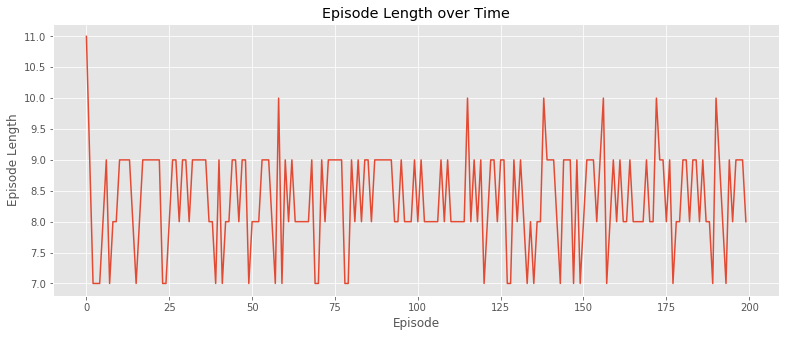

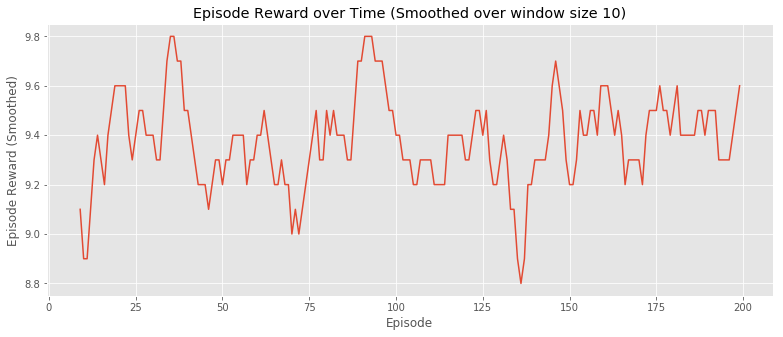

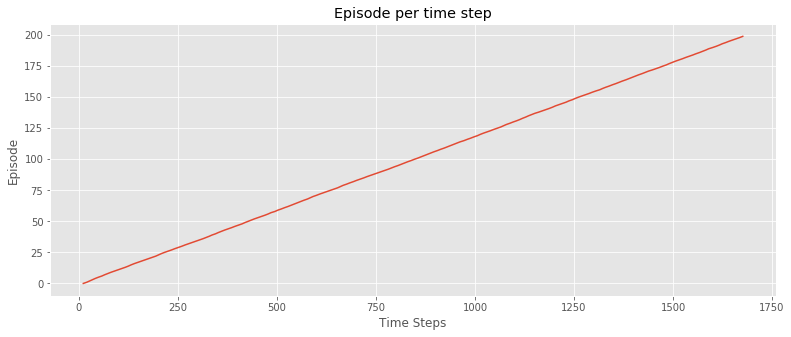

(<Figure size 936x360 with 1 Axes>,
 <Figure size 936x360 with 1 Axes>,
 <Figure size 936x360 with 1 Axes>)

In [9]:
import pandas as pd

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(13,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(13,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(13,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

plot_episode_stats(result)